In [1]:
#!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip

In [2]:
!git clone https://github.com/niazwazir/SRCNN-Keras.git

Cloning into 'SRCNN-Keras'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 81 (delta 2), reused 0 (delta 0), pack-reused 72
Unpacking objects: 100% (81/81), done.


In [3]:
cd SRCNN-Keras/

/content/SRCNN-Keras


In [4]:
#!ls

In [5]:
!unzip yang91.zip

Archive:  yang91.zip
   creating: yang91/
  inflating: yang91/tt9.bmp          
  inflating: yang91/tt8.bmp          
  inflating: yang91/tt7.bmp          
  inflating: yang91/tt6.bmp          
  inflating: yang91/tt5.bmp          
  inflating: yang91/tt4.bmp          
  inflating: yang91/tt3.bmp          
  inflating: yang91/tt27.bmp         
  inflating: yang91/tt26.bmp         
  inflating: yang91/tt25.bmp         
  inflating: yang91/tt24.bmp         
  inflating: yang91/tt23.bmp         
  inflating: yang91/tt22.bmp         
  inflating: yang91/tt21.bmp         
  inflating: yang91/tt20.bmp         
  inflating: yang91/tt2.bmp          
  inflating: yang91/tt19.bmp         
  inflating: yang91/tt18.bmp         
  inflating: yang91/tt17.bmp         
  inflating: yang91/tt16.bmp         
  inflating: yang91/tt15.bmp         
  inflating: yang91/tt14.bmp         
  inflating: yang91/tt13.bmp         
  inflating: yang91/tt12.bmp         
  inflating: yang91/tt10.bmp         
  inflat

In [6]:
#!ls

In [7]:
!rm -r *.zip

In [8]:
#!ls

In [9]:
cd ..

/content


In [10]:
#!ls

In [11]:
#!unzip "DIV2K_train_HR.zip"

In [12]:
#!rm -r *.zip

In [13]:
#!ls

In [14]:
############### IF YOU DON'T WANT TO TRAIN :
############### Load my github model and use the output patch prediction and merging code from this same notebook lateron

In [15]:
DATADIR = "SRCNN-Keras/yang91"
DATADIR2 = "SRCNN-Keras/yang91"
#DATADIR2 = "DIV2K_train_HR"


In [16]:
import os
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

In [17]:
scale = 2
req_size = 20
inp_size = int(req_size/scale)
stride = 15

X=[]
labels=[]

for filera in os.listdir(DATADIR):
  readpath = os.path.join(DATADIR,filera)
  img = cv2.imread(readpath)
  img = np.asarray(img)
  shapes = img.shape
  for i in range(0, shapes[0]-req_size+1, stride):
    for j in range(0, shapes[1]-req_size+1,stride):
      subimage_HR = img[i:i+req_size, j:j+req_size]
      #cv2_imshow(subimage_HR)
      subimage_LR = cv2.resize(subimage_HR,(inp_size,inp_size))
      X.append(subimage_LR)
      labels.append(subimage_HR)

counta=0
for filera in os.listdir(DATADIR2):
  counta=counta+1
  if(counta==300):
    break
  readpath = os.path.join(DATADIR2,filera)
  img = cv2.imread(readpath)
  img = np.asarray(img)
  shapes = img.shape
  for i in range(0, shapes[0]-req_size+1, stride):
    for j in range(0, shapes[1]-req_size+1,stride):
      subimage_HR = img[i:i+req_size, j:j+req_size]
      #cv2_imshow(subimage_HR)
      subimage_LR = cv2.resize(subimage_HR,(inp_size,inp_size))
      X.append(subimage_LR)
      labels.append(subimage_HR)

In [18]:
X = np.asarray(X)
labels = np.asarray(labels)
print(labels.shape)
print(X.shape)

(37698, 20, 20, 3)
(37698, 10, 10, 3)


In [19]:
import tensorflow as tf
import keras
import numpy as np
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, Activation, Input,Conv2DTranspose,MaxPooling2D, AveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras.layers import LeakyReLU
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
from keras.layers import Input, Conv2D, Activation, SeparableConv2D
from keras.layers.advanced_activations import PReLU
from keras.layers import Input, Conv2D, Activation, UpSampling2D

In [20]:
alpha = 0.85
def basic_mse(y_true, y_pred):
  pred = tf.image.sobel_edges(y_pred)
  true = tf.image.sobel_edges(y_true)
  lossmse = tf.reduce_mean(tf.square(y_pred-y_true))
  lossedge = tf.reduce_mean(tf.square(pred-true))
  return alpha*lossmse + (1-alpha)*lossedge

In [21]:
inputlayer = tf.keras.layers.Input(shape=(None,None,3))
############CHANNEL ATTENTION BRANCH#############
C1 = SeparableConv2D(56,(3,3),padding='SAME',name='DEPTHWISESEPARABLECONV_1')(inputlayer)
A1 = Activation('relu', name='PReLU_ACTIVATION_1')(C1)
AP1=MaxPooling2D(pool_size=(2,2), strides=(2,2))(A1)
AP2=AveragePooling2D(pool_size=(2,2), strides=(2,2))(A1)
AP3=MaxPooling2D(strides=(2,2))(A1)
Sum1  = tf.keras.layers.add([AP1,AP2,AP3])
C2 = Conv2D(56, (3,3),padding="same",name='1x1_DEPTHWISE_SEPARABLE_CONVOLUTION_1')(Sum1)
A2 = Activation('relu', name='PReLU_ACTIVATION_2')(C2)




############SPATIAL ATTENTION BRANCH#############
C3 = SeparableConv2D(56,(3,3),padding='SAME',name='DEPTHWISESEPARABLECONV_3')(inputlayer)
A3 = Activation('relu', name='PReLU_ACTIVATION_3')(C3)
AP22=MaxPooling2D(pool_size=(2,2), strides=(2,2))(A3)
AP23=AveragePooling2D(pool_size=(2,2), strides=(2,2))(A3)
AP24=MaxPooling2D(pool_size=(2,2), strides=(2,2))(A3)
Sum2  = tf.keras.layers.add([AP22,AP23,AP24])
C4 = Conv2D(56, (3,3),padding="same",name='1x1_DEPTHWISE_SEPARABLE_CONVOLUTION_4')(Sum2)
A4 = Activation('relu', name='PReLU_ACTIVATION_4')(C4)

Sum3  = tf.keras.layers.add([A2,A4])

y = Conv2DTranspose(3, (9,9), strides = (4,4), padding="same",activation=None,name='UPSCALING')(Sum3)
C2A = Conv2D(3, (1,1),padding="same",name='1x1_DEPTHWISE_SEPARABLE_CONVOLUTION_2')(y)
#A2 = Activation('relu', name='PReLU_ACTIVATION_3')(C2)
A3A = tf.keras.activations.sigmoid(C2A)


model = Model(inputs=inputlayer , outputs = A3A)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
DEPTHWISESEPARABLECONV_1 (Separ (None, None, None, 5 251         input_1[0][0]                    
__________________________________________________________________________________________________
DEPTHWISESEPARABLECONV_3 (Separ (None, None, None, 5 251         input_1[0][0]                    
__________________________________________________________________________________________________
PReLU_ACTIVATION_1 (Activation) (None, None, None, 5 0           DEPTHWISESEPARABLECONV_1[0][0]   
______________________________________________________________________________________________

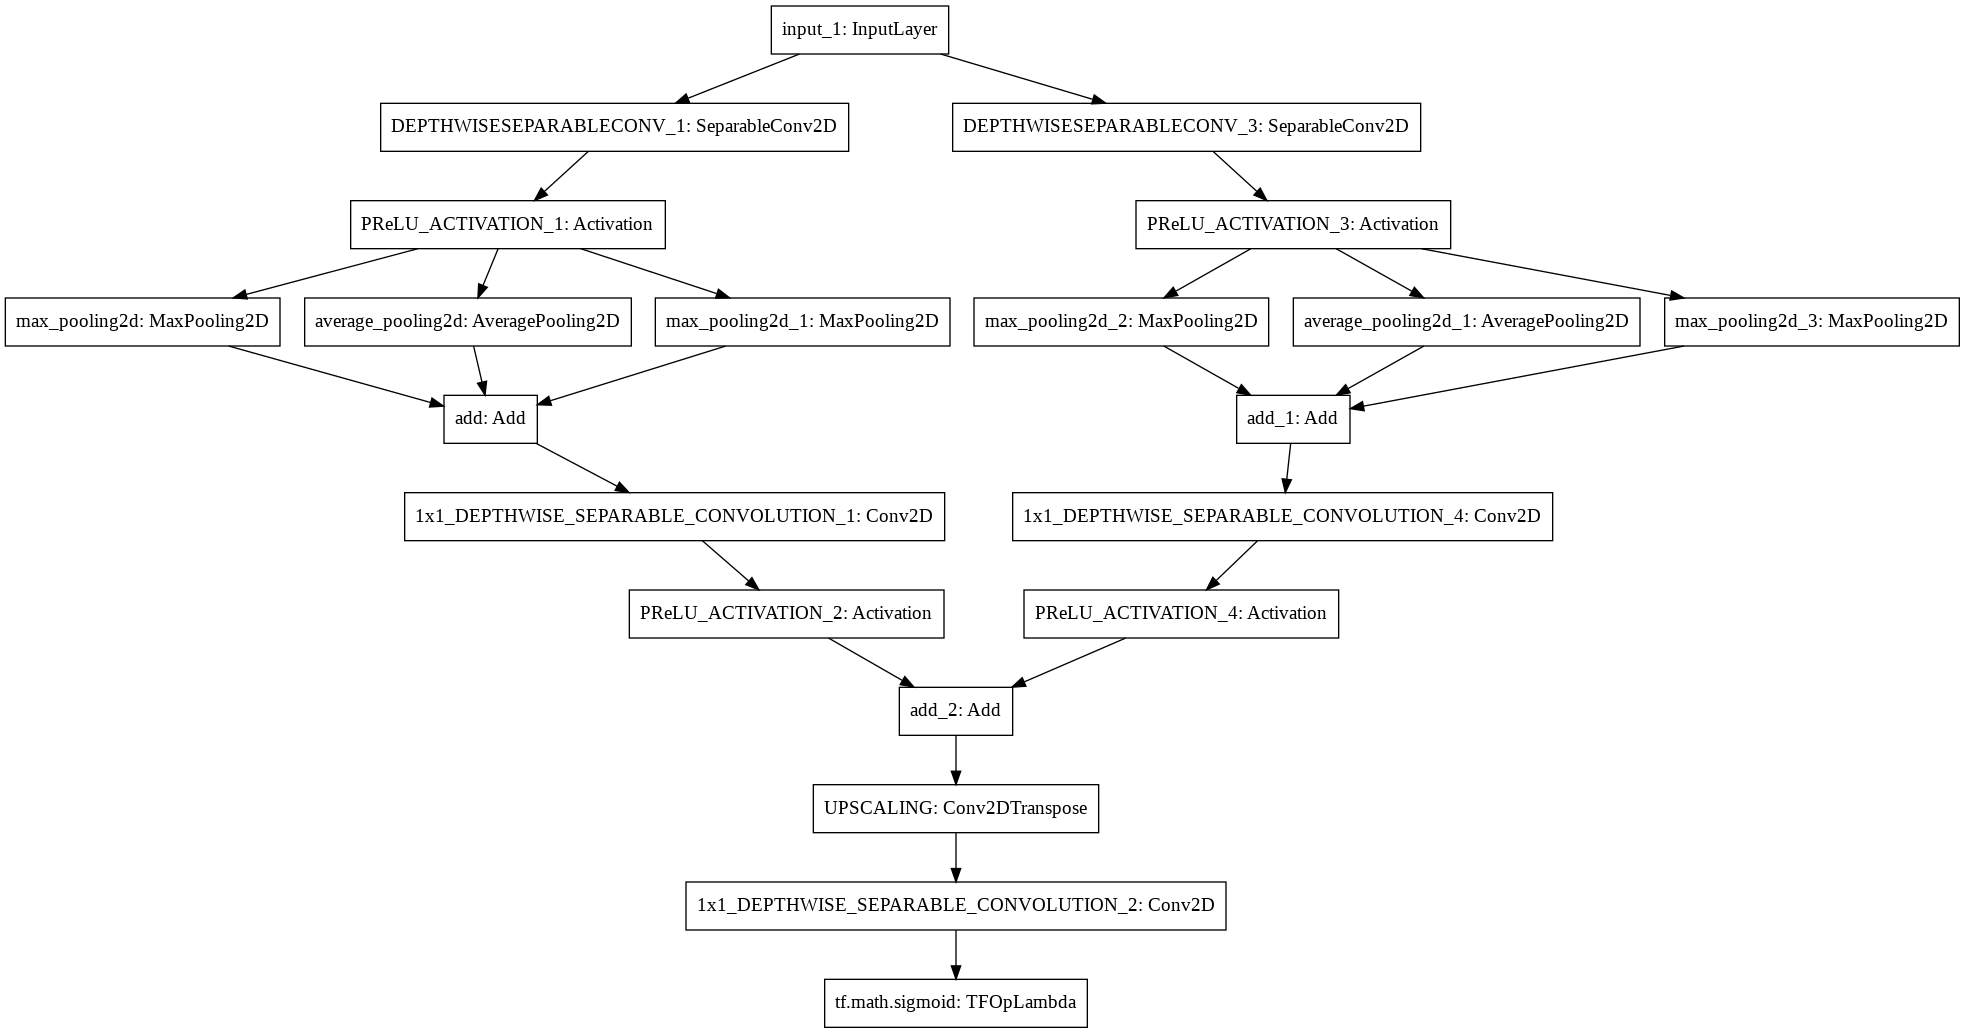

In [22]:
tf.keras.utils.plot_model(model, 'my_first_model.png')

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD

In [24]:
model.compile(loss='mse',
              optimizer='adam',
              metrics=['accuracy'])

In [25]:
checkpoint = ModelCheckpoint('best_model_improved.h5',  # model filename
                             monitor='val_loss', # quantity to monitor
                             verbose=0, # verbosity - 0 or 1
                             save_best_only= True, # The latest best model will not be overwritten
                             mode='auto') # The decision to overwrite model is made 
                                          # automatically depending on the quantity to monitor

In [26]:
history = model.fit(X,labels,batch_size=32,shuffle=True,validation_split=0.01 ,epochs=2,callbacks=[checkpoint],
                    verbose=1 )

Epoch 1/2
1167/1167 [==============================] - 39s 8ms/step - loss: 17240.3242 - accuracy: 0.1210 - val_loss: 19366.3535 - val_accuracy: 0.0352
Epoch 2/2
  16/1167 [..............................] - ETA: 8s - loss: 17594.9082 - accuracy: 0.0880

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


1167/1167 [==============================] - 8s 7ms/step - loss: 17238.8066 - accuracy: 0.1103 - val_loss: 19366.3535 - val_accuracy: 0.0352


In [27]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Loss Curves')

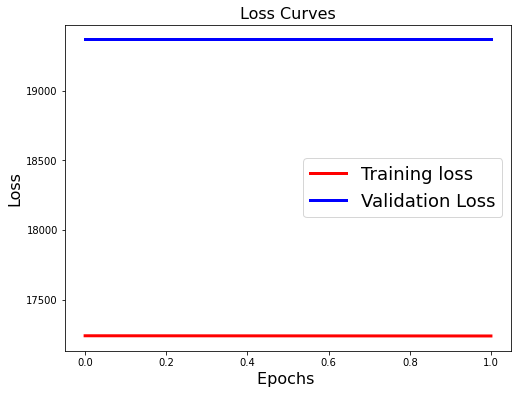

In [28]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

In [29]:
def psnr_calc():
  testimg = []
  #GT = cv2.imread("/content/drive/My Drive/dataset/suparesthing/test/set5/butterfly.png")
  GT = cv2.imread("SRCNN-Keras/baby_x2_GT.png")
  GT = np.asarray(GT)
  h = GT.shape[0]
  l = GT.shape[1]
  #print(GT.shape)
  img1 = cv2.resize(GT,(int(l/2),int(h/2)),interpolation = cv2.INTER_CUBIC)
  img1 = np.asarray(img1)
  testimg.append(img1)
  testimg = np.asarray(testimg)
  print(testimg.shape)
  fin =(model.predict(testimg)[0])
  inp = cv2.resize(img1,(l,h),interpolation = cv2.INTER_CUBIC)
  GT = GT[0:fin.shape[0],0:fin.shape[1],:]
  #mse = np.square(np.subtract(GT,inp)).mean()
  mse = np.square(np.subtract(GT, fin)).mean()
  cv2_imshow(inp)
  cv2_imshow(fin)
  cv2_imshow(GT)
  import math
  psnr = 20*math.log(255.0,10) - 10*(math.log(mse,10))
  return psnr

(1, 256, 256, 3)


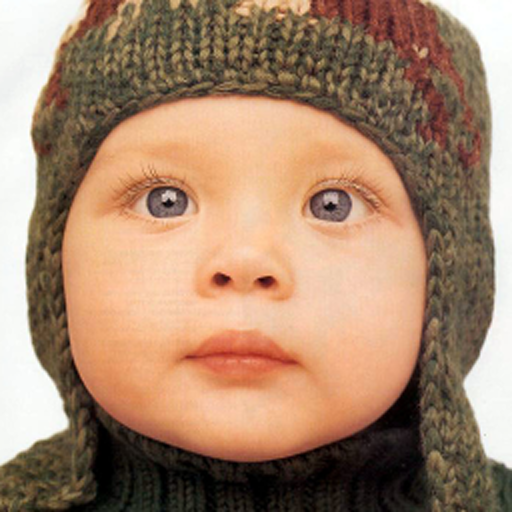

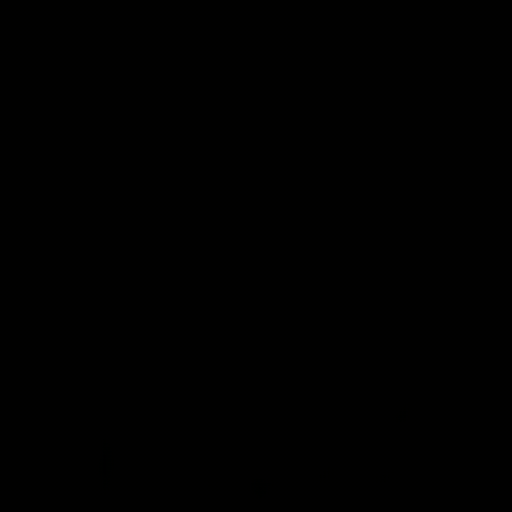

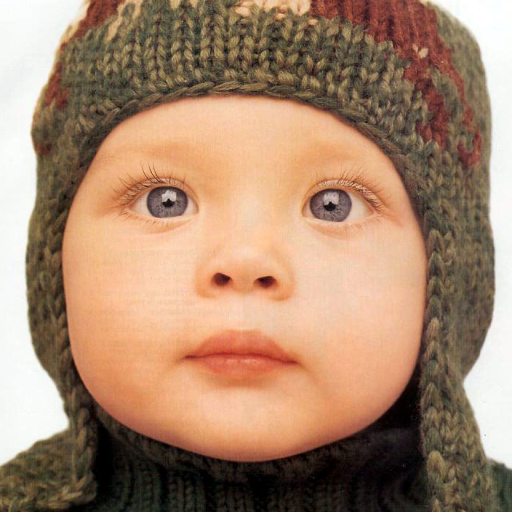

4.2552602965384025


In [30]:
ps1 = psnr_calc()
print(ps1)

In [31]:
!ls

best_model_improved.h5	my_first_model.png  sample_data  SRCNN-Keras


In [32]:
from google.colab import files
files.download('best_model_improved.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>